In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import train_test_split
import missingno as msno

df = pd.read_csv('result.csv')
rows_drop = []
for index,row in df.iterrows():
    if row[2:].isnull().sum()/len(row[2:])>0.5:
        rows_drop.append(index)
df_new = df.drop(rows_drop,axis=0)

tmp = df_new.drop(['region_name','date'],axis=1)

cols_drop = []
for col in tmp[0:0]:
    if df_new[col].isnull().sum()/180>0.5:
        cols_drop.append(col)
df_new = df_new.drop(cols_drop,axis=1)
df_new = df_new.fillna(0)
df = df_new
region = df.region_name.unique()

def split_region(i):
    val_state = np.array([region[i], region[i+1]])
    train = df.loc[~np.in1d(df['region_name'], val_state)]
    val = df.loc[np.in1d(df['region_name'], val_state)]
    return (train, val)

def cross_val(neigh,typ):
    score_list_cv = []
    
    if typ == "region":
        for i in range(0,5):
            train, val = split_region(i)
            x_train = train.iloc[:,2:-1]
            y_train = train.iloc[:, -1]
            x_val = val.iloc[:,2:-1]
            y_val = val.iloc[:,-1] 
    
            neigh.fit(x_train, y_train)
            y_pred = neigh.predict(x_val)
            score_list_cv.append(sqrt(metrics.mean_squared_error(y_val,y_pred)))
        return np.average(score_list_cv)
    
    elif typ == "time":
        for i in range(0,2):
            if i == 0:
                train = df.loc[df['date'] < '2020-08-10']
                val = df.loc[df['date'] >= '2020-08-10']
            else:
                train = df.loc[df['date'] >= '2020-08-10']
                val = df.loc[df['date'] < '2020-08-10']
            
            x_train = train.iloc[:,2:-1]
            y_train = train.iloc[:, -1]
            x_val = val.iloc[:,2:-1]
            y_val = val.iloc[:,-1] 
        
            neigh.fit(x_train, y_train)
            y_pred = neigh.predict(x_val)
            score_list_cv.append(sqrt(metrics.mean_squared_error(y_val,y_pred)))
        return np.average(score_list_cv)
        
    return 0


29.662218412920716
[34.2899748936549, 33.67581273135123, 33.140943073423685, 32.99064697498131, 32.203262369329025, 31.966380979957524, 31.766458694326168, 31.96191974939835, 31.799935827323424, 31.95490997368687, 31.880585445478197, 31.738990701242606, 31.852221983984936, 31.921158682539517, 31.734075815813185, 31.528087998195183, 31.553480827889054, 31.47269550890848, 31.3027815819595, 31.306625235057233, 31.43892179712219, 31.527481411743658, 31.379432389033134, 31.38744013647489, 31.394629398605012, 31.263950514528954, 31.14027131191391, 31.01040233608156, 30.892136389737495, 30.716010270789532, 30.590223113349953, 30.512799478722684, 30.385170642783578, 30.32002447772814, 30.266776899552646, 30.174962067988908, 30.074228977011607, 30.003773016952078, 29.93125496572022, 29.826055794405608, 29.79401103914929, 29.763611901139882, 29.72138227078107, 29.681815193651822, 29.704122230037928, 29.662218412920716, 29.688244888105782, 29.700261574986598, 29.74856128425853, 29.76722964784002,

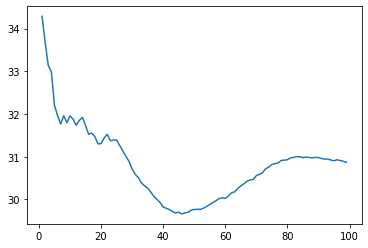

In [2]:
score_list = []
for k in range(1,100):
    score_list.append(cross_val(KNN(k),"region"))

print(min(score_list))
print(score_list)
plt.plot(range(1,100),score_list)

print(min(score_list))
print(score_list)

37.56924734669627
[39.629767030240274, 39.399300281943276, 40.00653355984483, 38.83478329107869, 40.15712250505891, 37.56924734669627, 40.19941980770287, 39.89880545056414, 39.15977366962952, 38.43516718362537, 38.24913304908442, 38.24913304908442, 38.24913304908442, 38.24913304908442, 38.24913304908442, 38.24913304908442, 38.24913304908442]


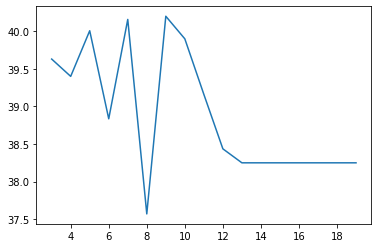

In [3]:
score_list = []
for k in range(3,20):
    #score_list.append(cross_val(DTR(max_depth=k)))
    score_list.append(cross_val(DTR(max_depth=k,random_state=10),"region"))
    
print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)

34.06825104630077
[34.42117258651946, 34.090742984516446, 34.59406065182011, 34.35685087551893, 34.711740125923605, 35.37033836357083, 34.893075365966425, 34.54462143828386, 34.33902017741811, 34.43041904814159, 34.06825104630077, 34.18252529710108, 34.179415038917995, 34.715354262340895, 34.807137660208994, 34.695500890568695, 34.63050363165392]


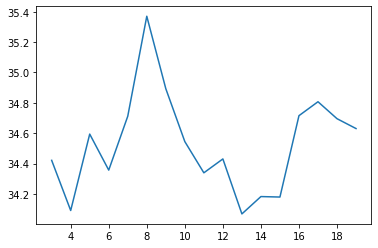

In [4]:
score_list = []
for k in range(3,20):
    score_list.append(cross_val(KNN(k),"time"))

print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)

33.359124230598894
[35.43197823644677, 36.04826503562785, 33.359124230598894, 33.424679364288494, 34.007529643260156, 34.04340060118194, 33.47500009255101, 37.298465276466864, 37.31627728545507, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115]


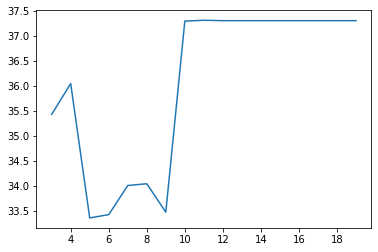

In [5]:
score_list = []
for k in range(3,20):
    #score_list.append(cross_val(DTR(max_depth=k)))
    score_list.append(cross_val(DTR(max_depth=k,random_state=10),"time"))
    
print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)

31.42398234894277


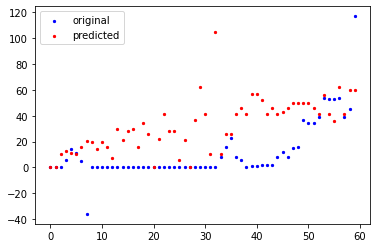

In [6]:
knn = KNN(2)

train, val = split_region(0)
knn.fit(train.iloc[:,3:-1], train.iloc[:,-1])
pred = knn.predict(val.iloc[:,3:-1])

print(sqrt(metrics.mean_squared_error(val.iloc[:,-1],pred)))

plt.scatter(range(len(val.iloc[:,-1])), val.iloc[:,-1], s=5, color="blue", label="original")
plt.scatter(range(len(val.iloc[:,-1])), pred, s=5, color="red", label="predicted")
plt.legend()
plt.show()


In [7]:
'''
df = pd.read_csv('result.csv')
rows_drop = []
for index,row in df.iterrows():
    if row[2:].isnull().sum()/len(row[2:])>0.5:
        rows_drop.append(index)
df_new = df.drop(rows_drop,axis=0)

tmp = df_new.drop(['region_name','date'],axis=1)

cols_drop = []
for col in tmp[0:0]:
    if df_new[col].isnull().sum()/180>0.5:
        cols_drop.append(col)
df_new = df_new.drop(cols_drop,axis=1)
df_new.to_csv('result_new.csv', index=False)
'''

#msno.matrix(df, labels=True)
#msno.matrix(df_new, labels=True)

"\ndf = pd.read_csv('result.csv')\nrows_drop = []\nfor index,row in df.iterrows():\n    if row[2:].isnull().sum()/len(row[2:])>0.5:\n        rows_drop.append(index)\ndf_new = df.drop(rows_drop,axis=0)\n\ntmp = df_new.drop(['region_name','date'],axis=1)\n\ncols_drop = []\nfor col in tmp[0:0]:\n    if df_new[col].isnull().sum()/180>0.5:\n        cols_drop.append(col)\ndf_new = df_new.drop(cols_drop,axis=1)\ndf_new.to_csv('result_new.csv', index=False)\n"

29.23878643734661
[44.32032468921104, 37.177610794181575, 32.79575872888495, 31.599825988935198, 31.140858817922823, 30.749043357912438, 30.03261612102048, 30.012649580300888, 29.405814572759716, 29.23878643734661, 29.342837651447702, 30.017184233359547, 30.131363592736772, 30.313927034080297, 29.823102063053494, 29.766207932930833, 29.924408636075395, 29.73619144677151, 30.238244016912297]


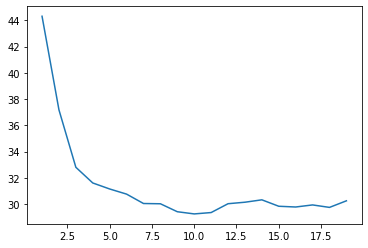

In [8]:
from sklearn.ensemble import RandomForestRegressor as RFR
score_list = []
for k in range(1,20):
    score_list.append(cross_val(RFR(k,random_state=10),"region"))

print(min(score_list))
print(score_list)
plt.plot(range(1,20),score_list)

31.202945268509602
[39.66845296442135, 34.631021339240974, 32.15799821980888, 31.202945268509602, 32.128145853138236, 32.660330866532846, 32.02216261455313, 32.22452449675867, 32.35846475151571, 33.833554532242694, 33.7794177384721, 33.64554940984638, 33.46241211201085, 33.366495488471514, 33.099835305724085, 33.00964566587598, 33.006906538561175, 32.97614668594139, 33.250772127774525]


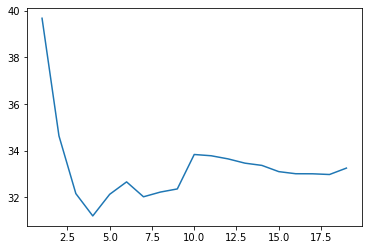

In [9]:
from sklearn.ensemble import RandomForestRegressor as RFR
score_list = []
for k in range(1,20):
    score_list.append(cross_val(RFR(k,random_state=10),"time"))

print(min(score_list))
print(score_list)
plt.plot(range(1,20),score_list)